# 3つの実験をしている

In [1]:
import csv
import json
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics, losses, callbacks

In [12]:
# 過去何ヶ月分みるか　分割数を決めている
SPLIT_SIZE = 24

In [3]:
# 入力するためのデータを生成する関数
def read_csv(csv_path):
    # ここのdatasに要素を入れている
    datas = list()

    # csvを開いている
    with open(csv_path, "r") as f:
        r = csv.reader(f)

        # 余分な文字列を空白に置換している
        items = [R.replace("\ufeff", "") for R in next(iter(r))]

        # Rは読み込んだcsvファイルを指している。enumerateはその中身の個数を数える関数
        # 今回は、iには読み込んだcsvの個数 Rには中の要素が入っている
        for i, R in enumerate(r):
            # 数値をfloat型にしている
            R = list(map(float, R))
            
            # 一番最新の月の要素をdatasに入れないようにする条件分岐
            if i == 0:
                tmp_peak = R[2]
                continue
            
            # csvから読み込んだ要素を入れる
            datas.append({
                I:V for I, V in zip(items, R)
            })
            # 来月と今月の差(gain)を出す
            datas[-1]["gain"] = tmp_peak - R[2]
            # 来月のpeakをnext_peakとしてリストに追加
            datas[-1]["next_peak"] = tmp_peak
            # gainを比率にしたものをgain_percentとしてリストに追加
            datas[-1]["gain_percent"] = (datas[-1]["next_peak"] - datas[-1]["peak"]) / datas[-1]["peak"] * 100
            # 
            tmp_peak = R[2]

            # データを昇順から降順にしたものを返す
    return list(reversed(datas))

# 標準化するための関数
def standardize_datas(datas):

    #要素名をitemsに入れている
    items = list(datas[-1].keys())

    # 平均の処理をしている
    mean_items = {
        I: np.average([D[I] for D in datas])  for I in items
    }
    # 標準偏差の処理をしている
    std_items = {
        I: np.std([D[I] for D in datas])  for I in items
    }
    # 標準化の処理を行っている
    standardized_datas = [
        # もし標準偏差の値が0の場合は0を入れる。それ以外は標準化の処理を行う
        {I:0.0 if std_items[I] == 0 else (D[I] - mean_items[I]) / std_items[I] for I in items} for D in datas
    ]

    return standardized_datas, mean_items, std_items

In [5]:
# データの読み込みをしている
csgo_datas = read_csv("dataset/csgo_dataset5.csv")

#データの形と長さの確認
csgo_datas, len(csgo_datas)

([{'year': 2013.0,
   'month': 1.0,
   'peak': 31359.0,
   'gain': 3879.0,
   'price': 0.0,
   'steam_online': 189534301.0,
   'next_peak': 35238.0,
   'gain_percent': 12.369654644599636},
  {'year': 2013.0,
   'month': 2.0,
   'peak': 35238.0,
   'gain': -3072.0,
   'price': 0.0,
   'steam_online': 156301691.0,
   'next_peak': 32166.0,
   'gain_percent': -8.717861399625404},
  {'year': 2013.0,
   'month': 3.0,
   'peak': 32166.0,
   'gain': -200.0,
   'price': 0.0,
   'steam_online': 159335892.0,
   'next_peak': 31966.0,
   'gain_percent': -0.6217745445501461},
  {'year': 2013.0,
   'month': 4.0,
   'peak': 31966.0,
   'gain': 21413.0,
   'price': 0.0,
   'steam_online': 150894913.0,
   'next_peak': 53379.0,
   'gain_percent': 66.98679847337796},
  {'year': 2013.0,
   'month': 5.0,
   'peak': 53379.0,
   'gain': -19679.0,
   'price': 0.0,
   'steam_online': 152520560.0,
   'next_peak': 33700.0,
   'gain_percent': -36.86655800970419},
  {'year': 2013.0,
   'month': 6.0,
   'peak': 3370

In [6]:
# 標準化したデータ、平均を出したデータ、標準偏差を出したデータにするように関数で呼び出しをしている
standardized_csgo_datas, csgo_mean_items, csgo_std_items = standardize_datas(csgo_datas)

In [8]:
csgo_mean_items

{'year': 2017.4621848739496,
 'month': 6.453781512605042,
 'peak': 648259.2521008403,
 'gain': 8686.72268907563,
 'price': 570.5126050420168,
 'steam_online': 450737855.26890755,
 'next_peak': 656945.974789916,
 'gain_percent': 4.1408098115332965}

In [7]:
standardized_csgo_datas

[{'year': -1.5632529387114606,
  'month': -1.5903232807779717,
  'peak': -1.9181081145309107,
  'gain': -0.06108947074816852,
  'price': -0.8216822139375214,
  'steam_online': -1.2428713760952992,
  'next_peak': -1.9502280281700042,
  'gain_percent': 0.5105981069787495},
 {'year': -1.5632529387114606,
  'month': -1.298723172284014,
  'peak': -1.906047264578382,
  'gain': -0.14941255812910118,
  'price': -0.8216822139375214,
  'steam_online': -1.4010003871554486,
  'next_peak': -1.9598645468338716,
  'gain_percent': -0.797877868871324},
 {'year': -1.5632529387114606,
  'month': -1.0071230637900561,
  'peak': -1.9155989353837874,
  'gain': -0.11291940506363742,
  'price': -0.8216822139375214,
  'steam_online': -1.3865629053119304,
  'next_peak': -1.9604919243510506,
  'gain_percent': -0.29551736675980744},
 {'year': -1.5632529387114606,
  'month': -0.7155229552960982,
  'peak': -1.9162207889518479,
  'gain': 0.16170681958952005,
  'price': -0.8216822139375214,
  'steam_online': -1.426727

In [13]:
# 入力信号
x = list()
# 教師信号
y = list()

# 過去○ヶ月分から教師信号を取るためSPLIT_SIZEからデータ数回繰り返す
for i in range(SPLIT_SIZE, len(standardized_csgo_datas)):
    # 入力信号を一時的に補完する箱
    tmp = list()
    y_tmp = list()
    # i - SPLIT_SIZEは前のfor文からみると0であり[0~データの個数]
    for D in standardized_csgo_datas[i - SPLIT_SIZE : i]:
        # 
        tmp_tmp = list()
        # Kには特定の変数の値を取るためのKeyが渡されている
        for K in D.keys():
            # 入力信号に入れるKeyだった時、tmp_tmpに要素を入れる
            if K in {"peak", "steam_online", "price"}:
                tmp_tmp.append( D[K] )
        # tmp_tmpに入れた全ての入力信号をtmpに入れる
        tmp.append( tmp_tmp )
        y_tmp.append(D["gain_percent"])
    # 入力信号に入れる
    x.append( tmp )
    # SPLIT_SIZEより前の教師信号は使わないので、それより後の教師信号を追加している
    y.append( y_tmp )


x = np.array(x)
y = np.array(y)

In [17]:
y[-1]

array([ 0.50223252, -0.46925675, -0.26282932,  0.15781692, -0.51839245,
       -0.58597279, -1.15445211, -1.36734568,  0.06017848,  0.82529955,
       -0.76749877,  0.24971828, -0.15750078,  0.01094694, -0.23479776,
       -0.30164233, -0.09839428, -0.80344085, -0.37328696, -0.10870865,
        0.48873403,  0.10392763, -0.37820902,  0.0319863 ])

In [70]:
# データの分割をしている　また分割した配列に番号付けをしている
train_index, test_index = train_test_split(list(range(len(x))), test_size = 0.1, )
# 番号付けをしたデータをもとにtrain_x,yの分割をしている
train_x, train_y = x[train_index], y[train_index]
# test_x,yも同様の動きを行っている
test_x, test_y = x[test_index], y[test_index]

#各問題とテストデータの形を出力している
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((104, 3, 3), (104, 3), (12, 3, 3), (12, 3))

# RNNで試す(1層)equence=False

In [72]:
def build_model():
    # 入力層
    input = layers.Input(shape = train_x.shape[1:])

    # 中間層
    x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = False)(input)

    # 出力層 全結合で、活性化関数は回帰にして出力している
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

model = build_model()
                # 損失関数MSE
model.compile(loss = losses.MeanSquaredError(),
              # 最適化アルゴリズムAdam    学習率は0.0001に設定している
              optimizer = optimizers.Adam(learning_rate = 0.0001))
model.summary()

mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
                                monitor = "val_loss",
                                mode = "min",
                                save_best_only = True)
history = model.fit(x = train_x, y = train_y, batch_size = len(x), epochs = 1500,
                    validation_data = (test_x, test_y), callbacks = mcp)

model = models.load_model("model.keras")
print(model.evaluate(test_x, test_y))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 3)]            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 1024)              1052672   
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 1,053,697
Trainable params: 1,053,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
1/1 [==============================] - 1s 878ms/step - loss: 1.0385 - val_loss: 0.8964
Epoch 2/1500
1/1 [==============================] - 0s 115ms/step - loss: 0.9882 - val_loss: 0.8881
Epoch 3/1500
1/1 [==============================] - 0s 42ms/step - loss: 0.9523 - val_loss: 0.8913
Epoch 4/1500
1

1/1 [==============================] - 0s 139ms/step


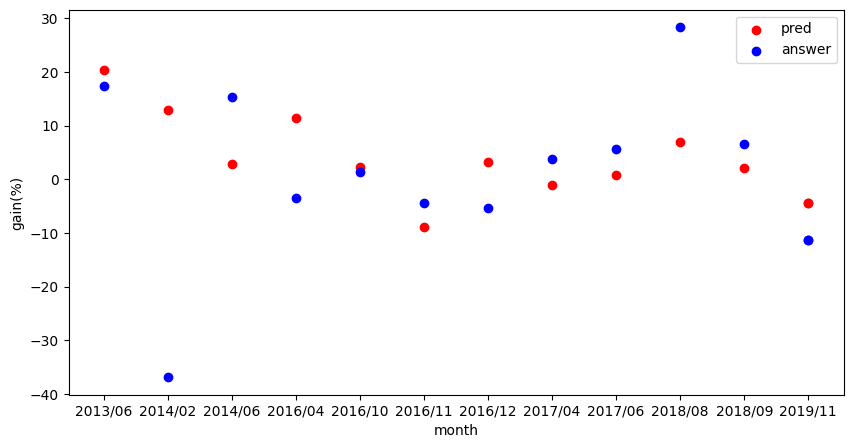

In [73]:
# 上で作ったmodelを使ってtestデータを使って予測をさせている
p = model.predict(test_x)

# 予測をした結果を、左から月ごとにソートを行いグラフにしている
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

tmp = list()
for TI in test_index:
    # インデックス番号　+　SPLIT_SIZEすることで、ランダムに抜き出した、データの年と月を出している
    tmp.append(f'{int(csgo_datas[TI + SPLIT_SIZE]["year"])}/{int(csgo_datas[TI + SPLIT_SIZE]["month"]):02}')
# 月を降順にソートする
tmp = list(sorted([[T, i] for i, T in enumerate(tmp)], key = lambda x : x[0]))

for i, (_, I) in enumerate(tmp):
    ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red")
    ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue")

ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red", label = "pred")
ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue", label = "answer")
ax.set_xticks(range(len(p)))
ax.set_xticklabels([T[0] for T in tmp])
ax.set_ylabel("gain(%)")
ax.set_xlabel("month")
ax.legend()

# LSTM(1層)sequence=False

In [74]:
def build_model():
    # 入力層
    input = layers.Input(shape = train_x.shape[1:])

    # 中間層
    x = layers.LSTM(units = 1024, activation = "relu", return_sequences = False)(input)

    # 出力層 全結合で、活性化関数は回帰にして出力している
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

model = build_model()
                # 損失関数MSE
model.compile(loss = losses.MeanSquaredError(),
              # 最適化アルゴリズムAdam    学習率は0.0001に設定している
              optimizer = optimizers.Adam(learning_rate = 0.0001))
model.summary()

mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
                                monitor = "val_loss",
                                mode = "min",
                                save_best_only = True)
history = model.fit(x = train_x, y = train_y, batch_size = len(x), epochs = 1500,
                    validation_data = (test_x, test_y), callbacks = mcp)

model = models.load_model("model.keras")
print(model.evaluate(test_x, test_y))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3, 3)]            0         
                                                                 
 lstm (LSTM)                 (None, 1024)              4210688   
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 4,211,713
Trainable params: 4,211,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
1/1 [==============================] - 1s 1s/step - loss: 1.0310 - val_loss: 0.8879
Epoch 2/1500
1/1 [==============================] - 0s 336ms/step - loss: 1.0258 - val_loss: 0.8860
Epoch 3/1500
1/1 [==============================] - 0s 403ms/step - loss: 1.0207 - val_loss: 0.8842
Epoch 4/1500
1/1

1/1 [==============================] - 0s 197ms/step


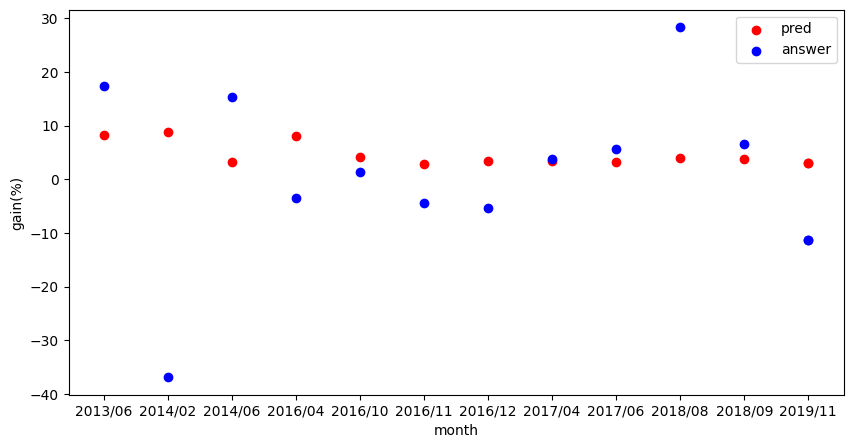

In [75]:
# 上で作ったmodelを使ってtestデータを使って予測をさせている
p = model.predict(test_x)

# 予測をした結果を、左から月ごとにソートを行いグラフにしている
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

tmp = list()
for TI in test_index:
    # インデックス番号　+　SPLIT_SIZEすることで、ランダムに抜き出した、データの年と月を出している
    tmp.append(f'{int(csgo_datas[TI + SPLIT_SIZE]["year"])}/{int(csgo_datas[TI + SPLIT_SIZE]["month"]):02}')
# 月を降順にソートする
tmp = list(sorted([[T, i] for i, T in enumerate(tmp)], key = lambda x : x[0]))

for i, (_, I) in enumerate(tmp):
    ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red")
    ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue")

ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red", label = "pred")
ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue", label = "answer")
ax.set_xticks(range(len(p)))
ax.set_xticklabels([T[0] for T in tmp])
ax.set_ylabel("gain(%)")
ax.set_xlabel("month")
ax.legend()

# RNNで試す(多層)equence=False

In [76]:
def build_model():
    # 入力層
    input = layers.Input(shape = train_x.shape[1:])

    # 中間層
    x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = True)(input)
    x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = True)(x)
    x = layers.SimpleRNN(units = 512, activation = "relu", return_sequences = True)(x)
    

    # 中間層最後のreturn_sequencesは、Falseにする
    # 出力は一つなので、中間層の最後で次元数を落として出力できるようにしている
    x = layers.SimpleRNN(units = 512, activation = "relu", return_sequences = False)(x)

    # 出力層 全結合で、活性化関数は回帰にして出力している
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

model = build_model()
                # 損失関数MSE
model.compile(loss = losses.MeanSquaredError(),
              # 最適化アルゴリズムAdam    学習率は0.0001に設定している
              optimizer = optimizers.Adam(learning_rate = 0.0001))
model.summary()

mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
                                monitor = "val_loss",
                                mode = "min",
                                save_best_only = True)
history = model.fit(x = train_x, y = train_y, batch_size = len(x), epochs = 1500,
                    validation_data = (test_x, test_y), callbacks = mcp)

model = models.load_model("model.keras")
print(model.evaluate(test_x, test_y))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3, 3)]            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 3, 1024)           1052672   
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 3, 1024)           2098176   
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 3, 512)            786944    
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 4,463,105
Trainable params: 4,463,105
Non-tra

1/1 [==============================] - 0s 405ms/step


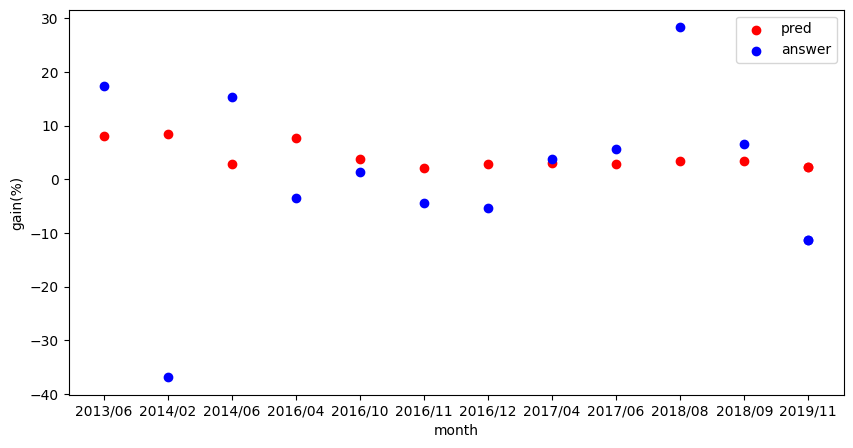

In [77]:
# 上で作ったmodelを使ってtestデータを使って予測をさせている
p = model.predict(test_x)

# 予測をした結果を、左から月ごとにソートを行いグラフにしている
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

tmp = list()
for TI in test_index:
    # インデックス番号　+　SPLIT_SIZEすることで、ランダムに抜き出した、データの年と月を出している
    tmp.append(f'{int(csgo_datas[TI + SPLIT_SIZE]["year"])}/{int(csgo_datas[TI + SPLIT_SIZE]["month"]):02}')
# 月を降順にソートする
tmp = list(sorted([[T, i] for i, T in enumerate(tmp)], key = lambda x : x[0]))

for i, (_, I) in enumerate(tmp):
    ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red")
    ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue")

ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red", label = "pred")
ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue", label = "answer")
ax.set_xticks(range(len(p)))
ax.set_xticklabels([T[0] for T in tmp])
ax.set_ylabel("gain(%)")
ax.set_xlabel("month")
ax.legend()

In [31]:
pre = model.predict(test_x)
ans = test_y

SINGLE_SE = list()

def single_sa(x, y):
    output = []
    for a, b in zip(x, y):
        c = a - b
        output.append(float(abs(c[0])))

    return output

# 標準化を元の縮尺に戻す関数
def decode(x):
    return x * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"]

for x, y in zip(pre, ans):
    SINGLE_SE.append(single_sa(decode(x), decode(y)))
    print(SINGLE_SE[-1][-1])
    
# SINGLE_SE[0]
    
min_SINGLE_SE = list()
max_SINGLE_SE = list()

for i in range(len(SINGLE_SE)):
    decode_min = min(SINGLE_SE[i])
    decode_min_index = SINGLE_SE[i].index(min(SINGLE_SE[i]))
    decode_max = max(SINGLE_SE[i])
    decode_max_index = SINGLE_SE[i].index(max(SINGLE_SE[i]))
    min_SINGLE_SE.append([decode_min, decode_min_index])
    max_SINGLE_SE.append([decode_max, decode_max_index])


1/1 [==============================] - 0s 61ms/step
0.04625219106674194
0.6407108306884766
0.3892660140991211
0.0666351318359375
0.6210851669311523
0.03276348114013672
0.04367828369140625
0.014240264892578125
0.019643306732177734
0.07885026931762695


In [32]:
# 各入力データの1〜24(SPILT_SIZE)の中の最大、最小(上からグラフのソート順になってる)
for a ,b in zip(min_SINGLE_SE,max_SINGLE_SE):
    print(f"min : {a[1]}番目 {a[0]:.5}%, max : {b[1]}番目 {b[0]:.5}%")

min : 21番目 0.042561%, max : 5番目 13.052%
min : 15番目 0.07416%, max : 1番目 57.156%
min : 21番目 0.011821%, max : 0番目 23.15%
min : 18番目 0.039036%, max : 2番目 48.14%
min : 20番目 0.11667%, max : 3番目 48.094%
min : 20番目 0.0042572%, max : 1番目 14.874%
min : 22番目 0.017521%, max : 0番目 24.007%
min : 23番目 0.01424%, max : 2番目 47.377%
min : 18番目 0.001091%, max : 2番目 12.261%
min : 22番目 0.0058451%, max : 2番目 20.453%


In [33]:
pre = model.predict(test_x)
ans = test_y

# 各検証データの予測と正解のMSEをとる
def mse(x, y):
    tmp = 0.0
    for a, b in zip(x, y):
        tmp += (a - b) ** 2
    tmp /= len(x)
    return tmp
# 各検証データに含まれるNヶ月の各予測と正解の二乗和誤差を算出する
def single_se(x, y):
    output = []
    for a, b in zip(x, y):
        output.append((a - b) ** 2)

    return output

MSE = []
SINGLE_SE = []

for x, y in zip(pre, ans):
    MSE.append(mse(x, y))
    SINGLE_SE.append(single_se(x, y))

1/1 [==============================] - 0s 80ms/step


In [34]:
print(f"MSEの最小値：{min(MSE)}、最大値：{max(MSE)}")
print()
for i in range(len(SINGLE_SE)):
    print(f"{i}個目の検証用データにおけるSingle MSEの最小値：{min(SINGLE_SE[i])}、最大値：{max(SINGLE_SE[i])}")

MSEの最小値：[0.04170025]、最大値：[1.3652302]

0個目の検証用データにおけるSingle MSEの最小値：[6.9743687e-06]、最大値：[0.6558595]
1個目の検証用データにおけるSingle MSEの最小値：[2.1173604e-05]、最大値：[12.577825]
2個目の検証用データにおけるSingle MSEの最小値：[5.378397e-07]、最大値：[2.063346]
3個目の検証用データにおけるSingle MSEの最小値：[5.866541e-06]、最大値：[8.922792]
4個目の検証用データにおけるSingle MSEの最小値：[5.2408068e-05]、最大値：[8.905441]
5個目の検証用データにおけるSingle MSEの最小値：[6.975313e-08]、最大値：[0.85185206]
6個目の検証用データにおけるSingle MSEの最小値：[1.1819793e-06]、最大値：[2.2190425]
7個目の検証用データにおけるSingle MSEの最小値：[7.807123e-07]、最大値：[8.642171]
8個目の検証用データにおけるSingle MSEの最小値：[4.584763e-09]、最大値：[0.5788471]
9個目の検証用データにおけるSingle MSEの最小値：[1.3152551e-07]、最大値：[1.6105521]


# LSTM(多層)sequence=False

In [78]:
def build_model():
    # 入力層
    input = layers.Input(shape = train_x.shape[1:])

    # 中間層
    x = layers.LSTM(units = 1024, activation = "relu", return_sequences = True)(input)
    x = layers.LSTM(units = 1024, activation = "relu", return_sequences = True)(x)
    x = layers.LSTM(units = 512, activation = "relu", return_sequences = True)(x)
    

    # 中間層最後のreturn_sequencesは、Falseにする
    # 出力は一つなので、中間層の最後で次元数を落として出力できるようにしている
    x = layers.LSTM(units = 512, activation = "relu", return_sequences = False)(x)

    # 出力層 全結合で、活性化関数は回帰にして出力している
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

model = build_model()
                # 損失関数MSE
model.compile(loss = losses.MeanSquaredError(),
              # 最適化アルゴリズムAdam    学習率は0.0001に設定している
              optimizer = optimizers.Adam(learning_rate = 0.0001))
model.summary()

mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
                                monitor = "val_loss",
                                mode = "min",
                                save_best_only = True)
history = model.fit(x = train_x, y = train_y, batch_size = len(x), epochs = 1500,
                    validation_data = (test_x, test_y), callbacks = mcp)

model = models.load_model("model.keras")
print(model.evaluate(test_x, test_y))


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 3)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 1024)           4210688   
                                                                 
 lstm_2 (LSTM)               (None, 3, 1024)           8392704   
                                                                 
 lstm_3 (LSTM)               (None, 3, 512)            3147776   
                                                                 
 lstm_4 (LSTM)               (None, 512)               2099200   
                                                                 
 dense_6 (Dense)             (None, 1)                 513       
                                                                 
Total params: 17,850,881
Trainable params: 17,850,881
Non-t

1/1 [==============================] - 1s 574ms/step


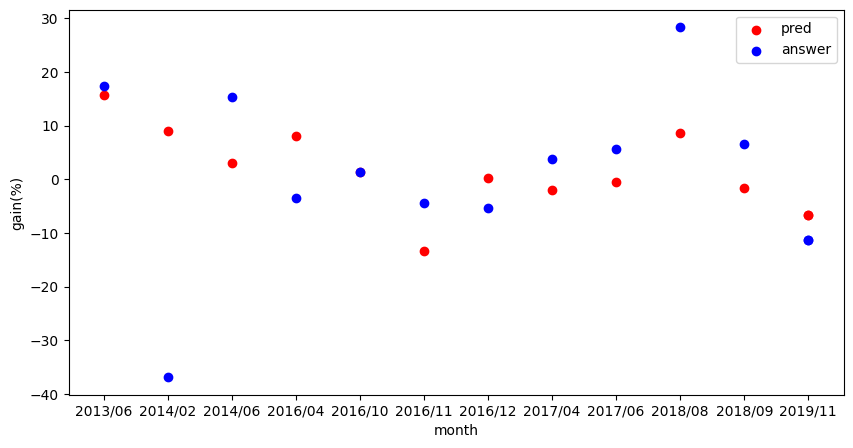

In [79]:
# 上で作ったmodelを使ってtestデータを使って予測をさせている
p = model.predict(test_x)

# 予測をした結果を、左から月ごとにソートを行いグラフにしている
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

tmp = list()
for TI in test_index:
    # インデックス番号　+　SPLIT_SIZEすることで、ランダムに抜き出した、データの年と月を出している
    tmp.append(f'{int(csgo_datas[TI + SPLIT_SIZE]["year"])}/{int(csgo_datas[TI + SPLIT_SIZE]["month"]):02}')
# 月を降順にソートする
tmp = list(sorted([[T, i] for i, T in enumerate(tmp)], key = lambda x : x[0]))

for i, (_, I) in enumerate(tmp):
    ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red")
    ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue")

ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red", label = "pred")
ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue", label = "answer")
ax.set_xticks(range(len(p)))
ax.set_xticklabels([T[0] for T in tmp])
ax.set_ylabel("gain(%)")
ax.set_xlabel("month")
ax.legend()

In [91]:
pre = model.predict(test_x)
ans = test_y

SINGLE_SE = list()

def single_sa(x, y):
    output = []
    for a, b in zip(x, y):
        c = a - b
        output.append(float(c[0]))

    return output

# 標準化を元の縮尺に戻す関数
def decode(x):
    return x * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"]

for x, y in zip(pre, ans):
    SINGLE_SE.append(single_sa(x, y))
SINGLE_SE[0]

min_SINGLE_SE = list()
max_SINGLE_SE = list()

for i in range(len(SINGLE_SE)):
    decode_min = decode(min(SINGLE_SE[i]))
    decode_min_index = SINGLE_SE[i].index(min(SINGLE_SE[i]))
    decode_max = decode(max(SINGLE_SE[i]))
    decode_max_index = SINGLE_SE[i].index(max(SINGLE_SE[i]))
    min_SINGLE_SE.append([decode_min, decode_min_index])
    max_SINGLE_SE.append([decode_max, decode_max_index])


1/1 [==============================] - 0s 179ms/step


[0.5797253251075745,
 0.4915603995323181,
 -0.8667244911193848,
 -0.5,
 -0.23478007316589355,
 0.6816413998603821,
 -0.36398664116859436,
 -0.6307228803634644,
 0.10846006870269775,
 -0.0008369386196136475,
 0.002753734588623047,
 0.06834695488214493,
 0.0017560720443725586,
 -0.07213879376649857,
 -0.03258407115936279,
 -0.06198304891586304,
 -0.005166113376617432,
 0.045560240745544434,
 0.07029014825820923,
 -0.029395341873168945,
 -0.047061145305633545,
 0.08965520560741425,
 -0.036761268973350525,
 -0.06668856739997864]

In [125]:
# 各入力データの1〜24(SPILT_SIZE)の中の最大、最小(上からグラフのソート順になってる)
for a ,b in zip(min_SINGLE_SE,max_SINGLE_SE):
    print(f"min : {a[1]}番目 {a[0]:.5}%, max : {b[1]}番目 {b[0]:.5}%")

min : 2番目 -9.8274%, max : 5番目 15.126%
min : 1番目 -8.5522%, max : 3番目 16.323%
min : 5番目 -3.2361%, max : 0番目 22.145%
min : 0番目 -4.5157%, max : 9番目 6.9924%
min : 4番目 0.4726%, max : 2番目 20.01%
min : 1番目 -20.866%, max : 2番目 14.728%
min : 4番目 -21.416%, max : 0番目 30.962%
min : 1番目 -40.847%, max : 0番目 20.163%
min : 0番目 -15.611%, max : 4番目 9.6603%
min : 6番目 -8.3548%, max : 2番目 32.923%


In [40]:
pre = model.predict(test_x)
ans = test_y

# 各検証データの予測と正解のMSEをとる
def mse(x, y):
    tmp = 0.0
    for a, b in zip(x, y):
        tmp += (a - b) ** 2
    tmp /= len(x)
    return tmp
# 各検証データに含まれるNヶ月の各予測と正解の二乗和誤差を算出する
def single_se(x, y):
    output = []
    for a, b in zip(x, y):
        output.append((a - b) ** 2)

    return output

MSE = []
SINGLE_SE = []

for x, y in zip(pre, ans):
    MSE.append(mse(x, y))
    SINGLE_SE.append(single_se(x, y))

1/1 [==============================] - 0s 407ms/step


In [48]:
print(f"MSEの最小値：{min(MSE)}、最大値：{max(MSE)}")
print()
for i in range(len(SINGLE_SE)):
    print(f"{i}個目の検証用データにおけるSingle MSEの最小値：{min(SINGLE_SE[i])}、最大値：{max(SINGLE_SE[i])}")

MSEの最小値：[0.02401841]、最大値：[0.43760762]

0個目の検証用データにおけるSingle MSEの最小値：[7.004663e-07]、最大値：[0.75121135]
1個目の検証用データにおけるSingle MSEの最小値：[1.6677279e-05]、最大値：[0.6203133]
2個目の検証用データにおけるSingle MSEの最小値：[1.7798055e-06]、最大値：[1.2479926]
3個目の検証用データにおけるSingle MSEの最小値：[0.00032992]、最大値：[0.28851172]
4個目の検証用データにおけるSingle MSEの最小値：[1.0455449e-05]、最大値：[0.96960247]
5個目の検証用データにおけるSingle MSEの最小値：[0.00047711]、最大値：[2.4077647]
6個目の検証用データにおけるSingle MSEの最小値：[0.00011431]、最大値：[2.7697968]
7個目の検証用データにおけるSingle MSEの最小値：[1.633222e-05]、最大値：[7.792389]
8個目の検証用データにおけるSingle MSEの最小値：[4.9529312e-06]、最大値：[1.5021144]
9個目の検証用データにおけるSingle MSEの最小値：[2.8256106e-06]、最大値：[3.1895304]


# RNN(1層)ミニバッチ

In [80]:
def build_model():
    # 入力層
    input = layers.Input(shape = train_x.shape[1:])

    # 中間層
    x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = False)(input)

    # 出力層 全結合で、活性化関数は回帰にして出力している
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

# ミニバッチ学習 
batch_size = len(train_x) // 4

model = build_model()
                # 損失関数MSE
model.compile(loss = losses.MeanSquaredError(),
              # 最適化アルゴリズムAdam    学習率は0.0001に設定している
              optimizer = optimizers.Adam(learning_rate = 0.0001))

# モデル構造の出力
model.summary()

# val_lossが一番低いモデルを保存している
mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
                                monitor = "val_loss",
                                mode = "min",
                                save_best_only = True)
# 学習データ、テストデータ、バッチサイズ、エポック、保存ポイントの設定
history = model.fit(x = train_x, y = train_y, batch_size = batch_size, epochs = 1500,
                    validation_data = (test_x, test_y), callbacks = mcp)

model = models.load_model("model.keras")
print(model.evaluate(test_x, test_y))

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3, 3)]            0         
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 1024)              1052672   
                                                                 
 dense_7 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 1,053,697
Trainable params: 1,053,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
4/4 [==============================] - 1s 144ms/step - loss: 1.0057 - val_loss: 0.8991
Epoch 2/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.9172 - val_loss: 0.9610
Epoch 3/1500
4/4 [==============================] - 0s 16ms/step - loss: 0.9060 - val_loss: 1.0079
Epoch 4/1500
4/

1/1 [==============================] - 0s 156ms/step


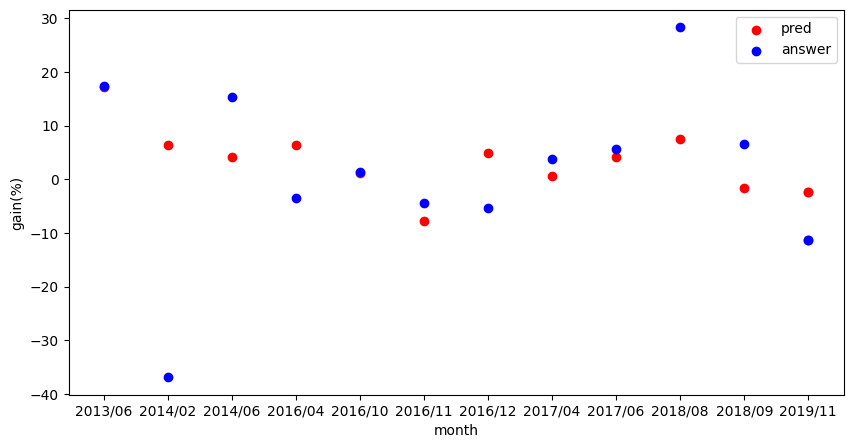

In [81]:
# 上で作ったmodelを使ってtestデータを使って予測をさせている
p = model.predict(test_x)

# 予測をした結果を、左から月ごとにソートを行いグラフにしている
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

tmp = list()
for TI in test_index:
    # インデックス番号　+　SPLIT_SIZEすることで、ランダムに抜き出した、データの年と月を出している
    tmp.append(f'{int(csgo_datas[TI + SPLIT_SIZE]["year"])}/{int(csgo_datas[TI + SPLIT_SIZE]["month"]):02}')
# 月を降順にソートする
tmp = list(sorted([[T, i] for i, T in enumerate(tmp)], key = lambda x : x[0]))

for i, (_, I) in enumerate(tmp):
    ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red")
    ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue")

ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red", label = "pred")
ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue", label = "answer")
ax.set_xticks(range(len(p)))
ax.set_xticklabels([T[0] for T in tmp])
ax.set_ylabel("gain(%)")
ax.set_xlabel("month")
ax.legend()

# LSTM(1層)ミニバッチ

In [82]:
def build_model():
    # 入力層
    input = layers.Input(shape = train_x.shape[1:])

    # 中間層
    x = layers.LSTM(units = 1024, activation = "relu", return_sequences = False)(input)

    # 出力層 全結合で、活性化関数は回帰にして出力している
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

# ミニバッチ学習 
batch_size = len(train_x) // 4

model = build_model()
                # 損失関数MSE
model.compile(loss = losses.MeanSquaredError(),
              # 最適化アルゴリズムAdam    学習率は0.0001に設定している
              optimizer = optimizers.Adam(learning_rate = 0.0001))

# モデル構造の出力
model.summary()

# val_lossが一番低いモデルを保存している
mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
                                monitor = "val_loss",
                                mode = "min",
                                save_best_only = True)
# 学習データ、テストデータ、バッチサイズ、エポック、保存ポイントの設定
history = model.fit(x = train_x, y = train_y, batch_size = batch_size, epochs = 1500,
                    validation_data = (test_x, test_y), callbacks = mcp)

model = models.load_model("model.keras")
print(model.evaluate(test_x, test_y))

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3, 3)]            0         
                                                                 
 lstm_5 (LSTM)               (None, 1024)              4210688   
                                                                 
 dense_8 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 4,211,713
Trainable params: 4,211,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
4/4 [==============================] - 1s 151ms/step - loss: 1.0385 - val_loss: 0.8855
Epoch 2/1500
4/4 [==============================] - 0s 96ms/step - loss: 1.0209 - val_loss: 0.8798
Epoch 3/1500
4/4 [==============================] - 0s 92ms/step - loss: 1.0038 - val_loss: 0.8760
Epoch 4/1500
4/

1/1 [==============================] - 0s 454ms/step


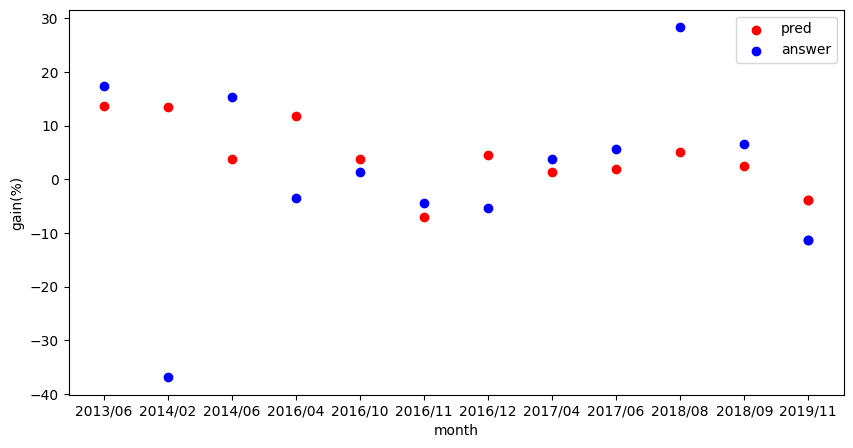

In [88]:
# 上で作ったmodelを使ってtestデータを使って予測をさせている
p = model.predict(test_x)

# 予測をした結果を、左から月ごとにソートを行いグラフにしている
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

tmp = list()
for TI in test_index:
    # インデックス番号　+　SPLIT_SIZEすることで、ランダムに抜き出した、データの年と月を出している
    tmp.append(f'{int(csgo_datas[TI + SPLIT_SIZE]["year"])}/{int(csgo_datas[TI + SPLIT_SIZE]["month"]):02}')
# 月を降順にソートする
tmp = list(sorted([[T, i] for i, T in enumerate(tmp)], key = lambda x : x[0]))

for i, (_, I) in enumerate(tmp):
    ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red")
    ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue")

ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red", label = "pred")
ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue", label = "answer")
ax.set_xticks(range(len(p)))
ax.set_xticklabels([T[0] for T in tmp])
ax.set_ylabel("gain(%)")
ax.set_xlabel("month")
ax.legend()

# RNN(多層)ミニバッチ

In [89]:
def build_model():
    # 入力層
    input = layers.Input(shape = train_x.shape[1:])

    # 中間層
    x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = True)(input)
    x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = True)(x)
    x = layers.SimpleRNN(units = 512, activation = "relu", return_sequences = True)(x)

    # 中間層最後のreturn_sequencesは、Falseにする
    # 出力は一つなので、中間層の最後で次元数を落として出力できるようにしている
    x = layers.SimpleRNN(units = 512, activation = "relu", return_sequences = False)(x)

    # 出力層 全結合で、活性化関数は回帰にして出力している
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

# ミニバッチ学習 
batch_size = len(train_x) // 4

model = build_model()
                # 損失関数MSE
model.compile(loss = losses.MeanSquaredError(),
              # 最適化アルゴリズムAdam    学習率は0.0001に設定している
              optimizer = optimizers.Adam(learning_rate = 0.0001))

# モデル構造の出力
model.summary()

# val_lossが一番低いモデルを保存している
mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
                                monitor = "val_loss",
                                mode = "min",
                                save_best_only = True)
# 学習データ、テストデータ、バッチサイズ、エポック、保存ポイントの設定
history = model.fit(x = train_x, y = train_y, batch_size = batch_size, epochs = 1500,
                    validation_data = (test_x, test_y), callbacks = mcp)

model = models.load_model("model.keras")
print(model.evaluate(test_x, test_y))


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 3, 3)]            0         
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, 3, 1024)           1052672   
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, 3, 1024)           2098176   
                                                                 
 simple_rnn_24 (SimpleRNN)   (None, 3, 512)            786944    
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, 512)               524800    
                                                                 
 dense_10 (Dense)            (None, 1)                 513       
                                                                 
Total params: 4,463,105
Trainable params: 4,463,105
Non-tr

In [ ]:
# 上で作ったmodelを使ってtestデータを使って予測をさせている
p = model.predict(test_x)

# 予測をした結果を、左から月ごとにソートを行いグラフにしている
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

tmp = list()
for TI in test_index:
    # インデックス番号　+　SPLIT_SIZEすることで、ランダムに抜き出した、データの年と月を出している
    tmp.append(f'{int(csgo_datas[TI + SPLIT_SIZE]["year"])}/{int(csgo_datas[TI + SPLIT_SIZE]["month"]):02}')
# 月を降順にソートする
tmp = list(sorted([[T, i] for i, T in enumerate(tmp)], key = lambda x : x[0]))

for i, (_, I) in enumerate(tmp):
    ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red")
    ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue")

ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red", label = "pred")
ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue", label = "answer")
ax.set_xticks(range(len(p)))
ax.set_xticklabels([T[0] for T in tmp])
ax.set_ylabel("gain(%)")
ax.set_xlabel("month")
ax.legend()

# LSTM(多層)ミニバッチ

# ミニバッチ学習を行う

In [38]:
def build_model():
    # 入力層
    input = layers.Input(shape = train_x.shape[1:])

    # 中間層
    x = layers.LSTM(units = 1024, activation = "relu", return_sequences = True)(input)
    x = layers.LSTM(units = 1024, activation = "relu", return_sequences = True)(x)
    x = layers.LSTM(units = 512, activation = "relu", return_sequences = True)(x)

    # 中間層最後のreturn_sequencesは、Falseにする
    # 出力は一つなので、中間層の最後で次元数を落として出力できるようにしている
    x = layers.LSTM(units = 512, activation = "relu", return_sequences = True)(x)

    # 出力層 全結合で、活性化関数は回帰にして出力している
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

# ミニバッチ学習 
batch_size = len(train_x) // 4

model = build_model()
                # 損失関数MSE
model.compile(loss = losses.MeanSquaredError(),
              # 最適化アルゴリズムAdam    学習率は0.0001に設定している
              optimizer = optimizers.Adam(learning_rate = 0.0001))

# モデル構造の出力
model.summary()

# val_lossが一番低いモデルを保存している
mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
                                monitor = "val_loss",
                                mode = "min",
                                save_best_only = True)
# 学習データ、テストデータ、バッチサイズ、エポック、保存ポイントの設定
history = model.fit(x = train_x, y = train_y, batch_size = batch_size, epochs = 1500,
                    validation_data = (test_x, test_y), callbacks = mcp)

model = models.load_model("model.keras")
print(model.evaluate(test_x, test_y))


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 24, 3)]           0         
                                                                 
 lstm_32 (LSTM)              (None, 24, 1024)          4210688   
                                                                 
 lstm_33 (LSTM)              (None, 24, 1024)          8392704   
                                                                 
 lstm_34 (LSTM)              (None, 24, 512)           3147776   
                                                                 
 lstm_35 (LSTM)              (None, 24, 512)           2099200   
                                                                 
 dense_8 (Dense)             (None, 24, 1)             513       
                                                                 
Total params: 17,850,881
Trainable params: 17,850,881
Non-t

1/1 [==============================] - 1s 757ms/step


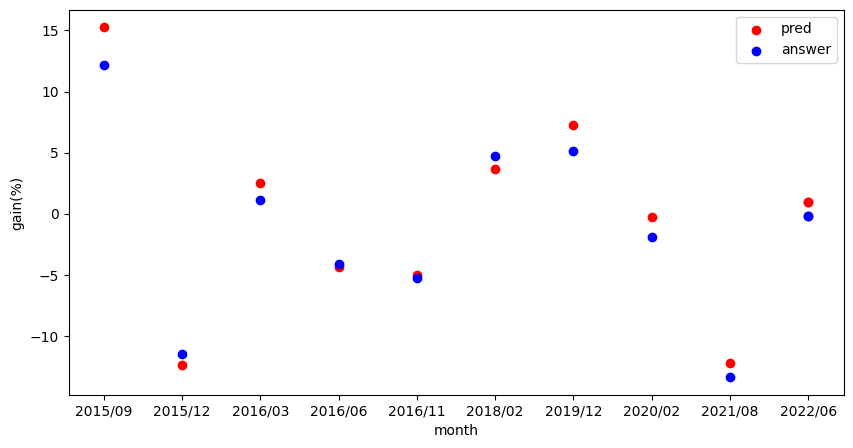

In [39]:
# 上で作ったmodelを使ってtestデータを使って予測をさせている
p = model.predict(test_x)

# 予測をした結果を、左から月ごとにソートを行いグラフにしている
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

tmp = list()
for TI in test_index:
    # インデックス番号　+　SPLIT_SIZEすることで、ランダムに抜き出した、データの年と月を出している
    tmp.append(f'{int(csgo_datas[TI + SPLIT_SIZE]["year"])}/{int(csgo_datas[TI + SPLIT_SIZE]["month"]):02}')
# 月を降順にソートする
tmp = list(sorted([[T, i] for i, T in enumerate(tmp)], key = lambda x : x[0]))

for i, (_, I) in enumerate(tmp):
    ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red")
    ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue")

ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red", label = "pred")
ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue", label = "answer")
ax.set_xticks(range(len(p)))
ax.set_xticklabels([T[0] for T in tmp])
ax.set_ylabel("gain(%)")
ax.set_xlabel("month")
ax.legend()

In [157]:
pre = model.predict(test_x)
ans = test_y

SINGLE_SE = list()

def single_sa(x, y):
    output = []
    for a, b in zip(x, y):
        c = a - b
        output.append(float(abs(c[0])))

    return output

# 標準化を元の縮尺に戻す関数
def decode(x):
    return x * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"]

for x, y in zip(pre, ans):
    SINGLE_SE.append(single_sa(decode(x), decode(y)))
    print(SINGLE_SE[-1][-1])
    
# SINGLE_SE[0]
    
min_SINGLE_SE = list()
max_SINGLE_SE = list()

for i in range(len(SINGLE_SE)):
    decode_min = min(SINGLE_SE[i])
    decode_min_index = SINGLE_SE[i].index(min(SINGLE_SE[i]))
    decode_max = max(SINGLE_SE[i])
    decode_max_index = SINGLE_SE[i].index(max(SINGLE_SE[i]))
    min_SINGLE_SE.append([decode_min, decode_min_index])
    max_SINGLE_SE.append([decode_max, decode_max_index])

1/1 [==============================] - 0s 47ms/step
2.0375919342041016
0.4616570472717285
1.20890474319458
0.3563652038574219
0.27797794342041016
0.3665475845336914
0.022635087370872498
0.09368133544921875
0.06367743015289307
0.5813674926757812


In [158]:
# 各入力データの1〜24(SPILT_SIZE)の中の最大、最小(上からグラフのソート順になってる)
for a ,b in zip(min_SINGLE_SE,max_SINGLE_SE):
    print(f"min : {a[1]}番目 {a[0]:.5}%, max : {b[1]}番目 {b[0]:.5}%")

min : 12番目 0.073784%, max : 2番目 21.677%
min : 17番目 0.16996%, max : 1番目 19.006%
min : 17番目 0.010042%, max : 0番目 18.46%
min : 7番目 0.030151%, max : 0番目 6.3995%
min : 17番目 0.19062%, max : 4番目 13.154%
min : 14番目 0.11348%, max : 1番目 32.907%
min : 23番目 0.022635%, max : 4番目 30.822%
min : 11番目 0.081562%, max : 1番目 59.107%
min : 1番目 0.028246%, max : 0番目 16.003%
min : 21番目 0.20636%, max : 3番目 18.315%


In [144]:
# 各入力データの1〜24(SPILT_SIZE)の中の最大、最小(上からグラフのソート順になってる)
for a ,b in zip(min_SINGLE_SE,max_SINGLE_SE):
    print(f"min : {a[1]}番目 {a[0]:.5}%, max : {b[1]}番目 {b[0]:.5}%")

min : 2番目 -17.536%, max : 3番目 21.909%
min : 1番目 -14.865%, max : 3番目 18.553%
min : 5番目 -2.11%, max : 0番目 22.601%
min : 0番目 -2.2587%, max : 3番目 8.9915%
min : 4番目 -9.0134%, max : 2番目 11.145%
min : 1番目 -28.766%, max : 2番目 22.514%
min : 4番目 -26.681%, max : 0番目 24.934%
min : 1番目 -54.966%, max : 2番目 15.677%
min : 0番目 -11.863%, max : 7番目 7.3986%
min : 6番目 0.85163%, max : 3番目 22.456%


In [155]:
for x, y in zip(pre, ans):
    print(decode(x[-1]), decode(y[-1]))
    

[2.6639042] 4.701496236845483
[-4.549385] -4.087727875951666
[-3.084021] -1.875116342494989
[5.4670167] 5.11065154553301
[-4.9881535] -5.266131407811356
[-13.019691] -13.386238954730098
[-0.16275835] -0.18539343328339886
[-11.553953] -11.460272081297521
[1.2039547] 1.14027731628719
[12.789329] 12.207961293590904


In [145]:
pre = model.predict(test_x)
ans = test_y

# 各検証データの予測と正解のMSEをとる
def mse(x, y):
    tmp = 0.0
    for a, b in zip(x, y):
        tmp += (a - b) ** 2
    tmp /= len(x)
    return tmp
# 各検証データに含まれるNヶ月の各予測と正解の二乗和誤差を算出する
def single_se(x, y):
    output = []
    for a, b in zip(x, y):
        output.append((a - b) ** 2)

    return output

MSE = []
SINGLE_SE = []

for x, y in zip(pre, ans):
    MSE.append(mse(x, y))
    SINGLE_SE.append(single_se(x, y))

1/1 [==============================] - 0s 51ms/step


In [146]:
print(f"MSEの最小値：{min(MSE)}、最大値：{max(MSE)}")
print()
for i in range(len(SINGLE_SE)):
    print(f"{i}個目の検証用データにおけるSingle MSEの最小値：{min(SINGLE_SE[i])}、最大値：{max(SINGLE_SE[i])}")

MSEの最小値：[0.02139824]、最大値：[0.6766705]

0個目の検証用データにおけるSingle MSEの最小値：[2.0960215e-05]、最大値：[1.8091338]
1個目の検証用データにおけるSingle MSEの最小値：[0.00011121]、最大値：[1.3907962]
2個目の検証用データにおけるSingle MSEの最小値：[3.8826227e-07]、最大値：[1.3120136]
3個目の検証用データにおけるSingle MSEの最小値：[3.5001567e-06]、最大値：[0.15767992]
4個目の検証用データにおけるSingle MSEの最小値：[0.00013991]、最大値：[0.6662126]
5個目の検証用データにおけるSingle MSEの最小値：[4.958292e-05]、最大値：[4.169263]
6個目の検証用データにおけるSingle MSEの最小値：[1.9725198e-06]、最大値：[3.657662]
7個目の検証用データにおけるSingle MSEの最小値：[2.5614028e-05]、最大値：[13.451243]
8個目の検証用データにおけるSingle MSEの最小値：[3.0716592e-06]、最大値：[0.9860603]
9個目の検証用データにおけるSingle MSEの最小値：[0.00016395]、最大値：[1.2914829]


# LSTM(多層)sequence=True

In [74]:
def build_model():
    # 入力層
    input = layers.Input(shape = train_x.shape[1:])

    # 中間層
    x = layers.LSTM(units = 1024, activation = "relu", return_sequences = True)(input)
    x = layers.LSTM(units = 1024, activation = "relu", return_sequences = True)(x)
    x = layers.LSTM(units = 512, activation = "relu", return_sequences = True)(x)
    # x = layers.LSTM(units = 512, activation = "relu", return_sequences = True)(x)
    

    # 中間層最後のreturn_sequencesは、Falseにする
    # 出力は一つなので、中間層の最後で次元数を落として出力できるようにしている
    x = layers.LSTM(units = 512, activation = "relu", return_sequences = True)(x)

    # 出力層 全結合で、活性化関数は回帰にして出力している
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

model = build_model()
                # 損失関数MSE
model.compile(loss = losses.MeanSquaredError(),
              # 最適化アルゴリズムAdam    学習率は0.0001に設定している
              optimizer = optimizers.Adam(learning_rate = 0.0001))
model.summary()

mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
                                monitor = "val_loss",
                                mode = "min",
                                save_best_only = True)
history = model.fit(x = train_x, y = train_y[:, -1], batch_size = len(x), epochs = 1500,
                    validation_data = (test_x, test_y[:, -1]), callbacks = mcp)

model = models.load_model("model.keras")
print(model.evaluate(test_x, test_y))


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 24, 3)]           0         
                                                                 
 lstm_33 (LSTM)              (None, 24, 1024)          4210688   
                                                                 
 lstm_34 (LSTM)              (None, 24, 1024)          8392704   
                                                                 
 lstm_35 (LSTM)              (None, 24, 512)           3147776   
                                                                 
 lstm_36 (LSTM)              (None, 512)               2099200   
                                                                 
 dense_8 (Dense)             (None, 1)                 513       
                                                                 
Total params: 17,850,881
Trainable params: 17,850,881
Non-t

In [78]:
test_y[:,-1].shape

(10,)

1/1 [==============================] - 0s 148ms/step


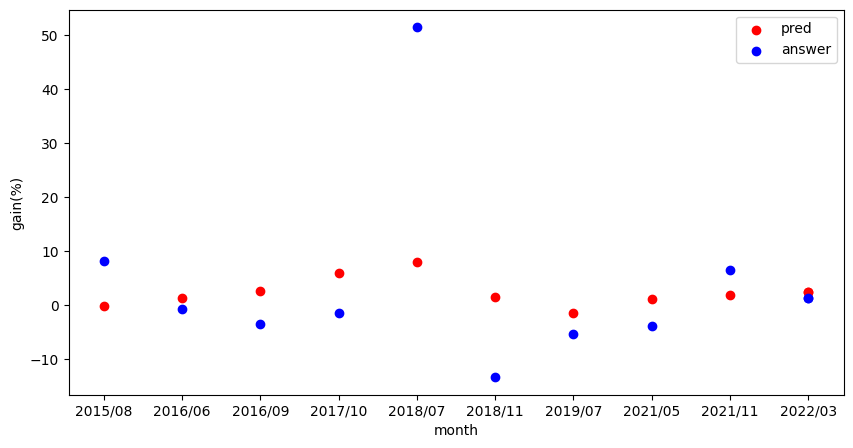

In [83]:
# 上で作ったmodelを使ってtestデータを使って予測をさせている
p = model.predict(test_x)

# 予測をした結果を、左から月ごとにソートを行いグラフにしている
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

tmp = list()
for TI in test_index:
    # インデックス番号　+　SPLIT_SIZEすることで、ランダムに抜き出した、データの年と月を出している
    tmp.append(f'{int(csgo_datas[TI + SPLIT_SIZE]["year"])}/{int(csgo_datas[TI + SPLIT_SIZE]["month"]):02}')
# 月を降順にソートする
tmp = list(sorted([[T, i] for i, T in enumerate(tmp)], key = lambda x : x[0]))

for i, (_, I) in enumerate(tmp):
    ax.scatter(i, p[tmp[I][1]] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red")
    ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue")

ax.scatter(i, p[tmp[I][1]] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red", label = "pred")
ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue", label = "answer")
ax.set_xticks(range(len(p)))
ax.set_xticklabels([T[0] for T in tmp])
ax.set_ylabel("gain(%)")
ax.set_xlabel("month")
ax.legend()

# ニューロン数を減らして　作成1

In [126]:
def build_model():
    # 入力層
    input = layers.Input(shape = train_x.shape[1:])

    # 中間層
    x = layers.LSTM(units = 128, activation = "relu", return_sequences = True)(input)
    x = layers.LSTM(units = 128, activation = "relu", return_sequences = True)(x)
    x = layers.LSTM(units = 64, activation = "relu", return_sequences = True)(x)

    # 中間層最後のreturn_sequencesは、Falseにする
    # 出力は一つなので、中間層の最後で次元数を落として出力できるようにしている
    x = layers.LSTM(units = 64, activation = "relu", return_sequences = True)(x)

    # 出力層 全結合で、活性化関数は回帰にして出力している
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

# ミニバッチ学習 
batch_size = len(train_x) // 4

model = build_model()
                # 損失関数MSE
model.compile(loss = losses.MeanSquaredError(),
              # 最適化アルゴリズムAdam    学習率は0.0001に設定している
              optimizer = optimizers.Adam(learning_rate = 0.0001))

# モデル構造の出力
model.summary()

# val_lossが一番低いモデルを保存している
mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
                                monitor = "val_loss",
                                mode = "min",
                                save_best_only = True)
# 学習データ、テストデータ、バッチサイズ、エポック、保存ポイントの設定
history = model.fit(x = train_x, y = train_y, batch_size = batch_size, epochs = 1500,
                    validation_data = (test_x, test_y), callbacks = mcp)

model = models.load_model("model.keras")
print(model.evaluate(test_x, test_y))

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 24, 3)]           0         
                                                                 
 lstm_36 (LSTM)              (None, 24, 128)           67584     
                                                                 
 lstm_37 (LSTM)              (None, 24, 128)           131584    
                                                                 
 lstm_38 (LSTM)              (None, 24, 64)            49408     
                                                                 
 lstm_39 (LSTM)              (None, 24, 64)            33024     
                                                                 
 dense_9 (Dense)             (None, 24, 1)             65        
                                                                 
Total params: 281,665
Trainable params: 281,665
Non-trainab

In [180]:
# # モデルを継続したまま、エポックを続けることができる     3回目6000回　回した
# model.compile(loss = losses.MeanSquaredError(),
#               # 最適化アルゴリズムAdam    学習率は0.0001に設定している
#               optimizer = optimizers.Adam(learning_rate = 0.0001))

# # モデル構造の出力
# model.summary()

# # val_lossが一番低いモデルを保存している
# mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
#                                 monitor = "val_loss",
#                                 mode = "min",
#                                 save_best_only = True)
# # 学習データ、テストデータ、バッチサイズ、エポック、保存ポイントの設定
# history = model.fit(x = train_x, y = train_y, batch_size = batch_size, epochs = 1500,
#                     validation_data = (test_x, test_y), callbacks = mcp)

# model = models.load_model("model.keras")
# print(model.evaluate(test_x, test_y))

1/1 [==============================] - 0s 52ms/step


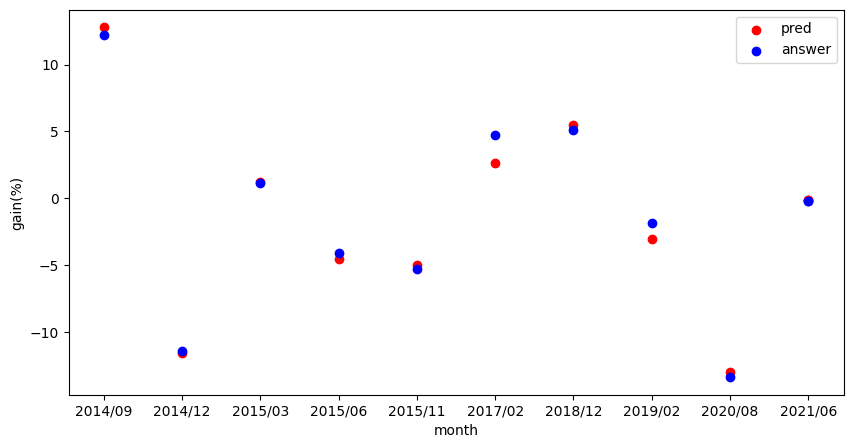

In [179]:
# 上で作ったmodelを使ってtestデータを使って予測をさせている
p = model.predict(test_x)

# 予測をした結果を、左から月ごとにソートを行いグラフにしている
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

tmp = list()
for TI in test_index:
    # インデックス番号　+　SPLIT_SIZEすることで、ランダムに抜き出した、データの年と月を出している
    tmp.append(f'{int(csgo_datas[TI + SPLIT_SIZE]["year"])}/{int(csgo_datas[TI + SPLIT_SIZE]["month"]):02}')
# 月を降順にソートする
tmp = list(sorted([[T, i] for i, T in enumerate(tmp)], key = lambda x : x[0]))

for i, (_, I) in enumerate(tmp):
    ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red")
    ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue")

ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red", label = "pred")
ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue", label = "answer")
ax.set_xticks(range(len(p)))
ax.set_xticklabels([T[0] for T in tmp])
ax.set_ylabel("gain(%)")
ax.set_xlabel("month")
ax.legend()

In [181]:
pre = model.predict(test_x)
ans = test_y

SINGLE_SE = list()

def single_sa(x, y):
    output = []
    for a, b in zip(x, y):
        c = a - b
        output.append(float(abs(c[0])))

    return output

# 標準化を元の縮尺に戻す関数
def decode(x):
    return x * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"]

for x, y in zip(pre, ans):
    SINGLE_SE.append(single_sa(decode(x), decode(y)))
    print(SINGLE_SE[-1][-1])
    
# SINGLE_SE[0]
    
min_SINGLE_SE = list()
max_SINGLE_SE = list()

for i in range(len(SINGLE_SE)):
    decode_min = min(SINGLE_SE[i])
    decode_min_index = SINGLE_SE[i].index(min(SINGLE_SE[i]))
    decode_max = max(SINGLE_SE[i])
    decode_max_index = SINGLE_SE[i].index(max(SINGLE_SE[i]))
    min_SINGLE_SE.append([decode_min, decode_min_index])
    max_SINGLE_SE.append([decode_max, decode_max_index])

1/1 [==============================] - 0s 53ms/step
2.0375919342041016
0.4616570472717285
1.20890474319458
0.3563652038574219
0.27797794342041016
0.3665475845336914
0.022635087370872498
0.09368133544921875
0.06367743015289307
0.5813674926757812


In [182]:
# 各入力データの1〜24(SPILT_SIZE)の中の最大、最小(上からグラフのソート順になってる)
for a ,b in zip(min_SINGLE_SE,max_SINGLE_SE):
    print(f"min : {a[1]}番目 {a[0]:.5}%, max : {b[1]}番目 {b[0]:.5}%")

min : 12番目 0.073784%, max : 2番目 21.677%
min : 17番目 0.16996%, max : 1番目 19.006%
min : 17番目 0.010042%, max : 0番目 18.46%
min : 7番目 0.030151%, max : 0番目 6.3995%
min : 17番目 0.19062%, max : 4番目 13.154%
min : 14番目 0.11348%, max : 1番目 32.907%
min : 23番目 0.022635%, max : 4番目 30.822%
min : 11番目 0.081562%, max : 1番目 59.107%
min : 1番目 0.028246%, max : 0番目 16.003%
min : 21番目 0.20636%, max : 3番目 18.315%


In [183]:
pre = model.predict(test_x)
ans = test_y

# 各検証データの予測と正解のMSEをとる
def mse(x, y):
    tmp = 0.0
    for a, b in zip(x, y):
        tmp += (a - b) ** 2
    tmp /= len(x)
    return tmp
# 各検証データに含まれるNヶ月の各予測と正解の二乗和誤差を算出する
def single_se(x, y):
    output = []
    for a, b in zip(x, y):
        output.append((a - b) ** 2)

    return output

MSE = []
SINGLE_SE = []

for x, y in zip(pre, ans):
    MSE.append(mse(x, y))
    SINGLE_SE.append(single_se(x, y))

1/1 [==============================] - 0s 42ms/step


In [184]:
print(f"MSEの最小値：{min(MSE)}、最大値：{max(MSE)}")
print()
for i in range(len(SINGLE_SE)):
    print(f"{i}個目の検証用データにおけるSingle MSEの最小値：{min(SINGLE_SE[i])}、最大値：{max(SINGLE_SE[i])}")

MSEの最小値：[0.02139824]、最大値：[0.6766705]

0個目の検証用データにおけるSingle MSEの最小値：[2.0960215e-05]、最大値：[1.8091338]
1個目の検証用データにおけるSingle MSEの最小値：[0.00011121]、最大値：[1.3907962]
2個目の検証用データにおけるSingle MSEの最小値：[3.8826227e-07]、最大値：[1.3120136]
3個目の検証用データにおけるSingle MSEの最小値：[3.5001567e-06]、最大値：[0.15767992]
4個目の検証用データにおけるSingle MSEの最小値：[0.00013991]、最大値：[0.6662126]
5個目の検証用データにおけるSingle MSEの最小値：[4.958292e-05]、最大値：[4.169263]
6個目の検証用データにおけるSingle MSEの最小値：[1.9725198e-06]、最大値：[3.657662]
7個目の検証用データにおけるSingle MSEの最小値：[2.5614028e-05]、最大値：[13.451243]
8個目の検証用データにおけるSingle MSEの最小値：[3.0716592e-06]、最大値：[0.9860603]
9個目の検証用データにおけるSingle MSEの最小値：[0.00016395]、最大値：[1.2914829]


# ニューロン数を減らして作成2

In [137]:
def build_model():
    # 入力層
    input = layers.Input(shape = train_x.shape[1:])

    # 中間層
    x = layers.LSTM(units = 256, activation = "relu", return_sequences = True)(input)
    x = layers.LSTM(units = 256, activation = "relu", return_sequences = True)(x)
    x = layers.LSTM(units = 128, activation = "relu", return_sequences = True)(x)

    # 中間層最後のreturn_sequencesは、Falseにする
    # 出力は一つなので、中間層の最後で次元数を落として出力できるようにしている
    x = layers.LSTM(units = 128, activation = "relu", return_sequences = True)(x)

    # 出力層 全結合で、活性化関数は回帰にして出力している
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

# ミニバッチ学習 
batch_size = len(train_x) // 4
# モデルの定義をしている
model = build_model()
                # 損失関数MSE
model.compile(loss = losses.MeanSquaredError(),
              # 最適化アルゴリズムAdam    学習率は0.0001に設定している
              optimizer = optimizers.Adam(learning_rate = 0.0001))

# モデル構造の出力
model.summary()

# val_lossが一番低いモデルを保存している
mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
                                monitor = "val_loss",
                                mode = "min",
                                save_best_only = True)
# 学習データ、テストデータ、バッチサイズ、エポック、保存ポイントの設定
history = model.fit(x = train_x, y = train_y, batch_size = batch_size, epochs = 1500,
                    validation_data = (test_x, test_y), callbacks = mcp)

model = models.load_model("model.keras")
print(model.evaluate(test_x, test_y))

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 24, 3)]           0         
                                                                 
 lstm_40 (LSTM)              (None, 24, 256)           266240    
                                                                 
 lstm_41 (LSTM)              (None, 24, 256)           525312    
                                                                 
 lstm_42 (LSTM)              (None, 24, 128)           197120    
                                                                 
 lstm_43 (LSTM)              (None, 24, 128)           131584    
                                                                 
 dense_10 (Dense)            (None, 24, 1)             129       
                                                                 
Total params: 1,120,385
Trainable params: 1,120,385
Non-tr

In [ ]:
# モデルを継続したまま、エポックを続けることができる     
model.compile(loss = losses.MeanSquaredError(),
              # 最適化アルゴリズムAdam    学習率は0.0001に設定している
              optimizer = optimizers.Adam(learning_rate = 0.0001))

# モデル構造の出力
model.summary()

# val_lossが一番低いモデルを保存している
mcp = callbacks.ModelCheckpoint(filepath = "model.keras",
                                monitor = "val_loss",
                                mode = "min",
                                save_best_only = True)
# 学習データ、テストデータ、バッチサイズ、エポック、保存ポイントの設定
history = model.fit(x = train_x, y = train_y, batch_size = batch_size, epochs = 1500,
                    validation_data = (test_x, test_y), callbacks = mcp)

model = models.load_model("model.keras")
print(model.evaluate(test_x, test_y))

1/1 [==============================] - 0s 46ms/step


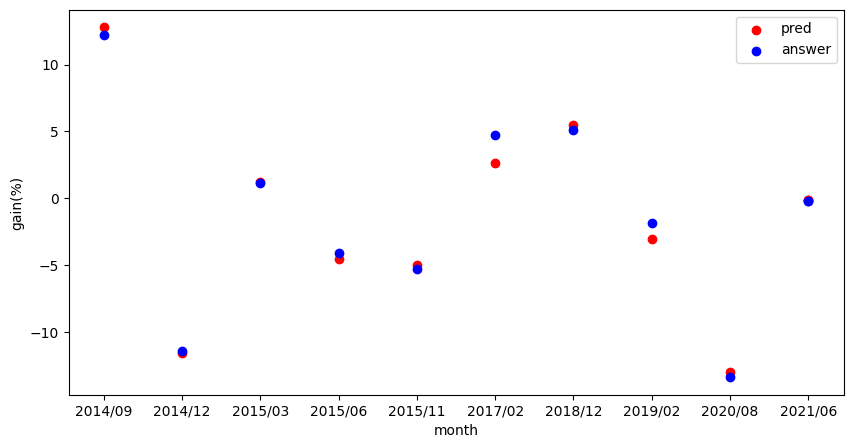

In [169]:
# 上で作ったmodelを使ってtestデータを使って予測をさせている
p = model.predict(test_x)

# 予測をした結果を、左から月ごとにソートを行いグラフにしている
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

tmp = list()
for TI in test_index:
    # インデックス番号　+　SPLIT_SIZEすることで、ランダムに抜き出した、データの年と月を出している
    tmp.append(f'{int(csgo_datas[TI + SPLIT_SIZE]["year"])}/{int(csgo_datas[TI + SPLIT_SIZE]["month"]):02}')
# 月を降順にソートする
tmp = list(sorted([[T, i] for i, T in enumerate(tmp)], key = lambda x : x[0]))

for i, (_, I) in enumerate(tmp):
    ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red")
    ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue")

ax.scatter(i, p[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "red", label = "pred")
ax.scatter(i, test_y[tmp[I][1]][-1] * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"], color = "blue", label = "answer")
ax.set_xticks(range(len(p)))
ax.set_xticklabels([T[0] for T in tmp])
ax.set_ylabel("gain(%)")
ax.set_xlabel("month")
ax.legend()

In [170]:
pre = model.predict(test_x)
ans = test_y

SINGLE_SE = list()

def single_sa(x, y):
    output = []
    for a, b in zip(x, y):
        c = a - b
        output.append(float(abs(c[0])))

    return output

# 標準化を元の縮尺に戻す関数
def decode(x):
    return x * csgo_std_items["gain_percent"] + csgo_mean_items["gain_percent"]

for x, y in zip(pre, ans):
    SINGLE_SE.append(single_sa(decode(x), decode(y)))
    print(SINGLE_SE[-1][-1])
    
# SINGLE_SE[0]
    
min_SINGLE_SE = list()
max_SINGLE_SE = list()

for i in range(len(SINGLE_SE)):
    decode_min = min(SINGLE_SE[i])
    decode_min_index = SINGLE_SE[i].index(min(SINGLE_SE[i]))
    decode_max = max(SINGLE_SE[i])
    decode_max_index = SINGLE_SE[i].index(max(SINGLE_SE[i]))
    min_SINGLE_SE.append([decode_min, decode_min_index])
    max_SINGLE_SE.append([decode_max, decode_max_index])

1/1 [==============================] - 0s 44ms/step
2.0375919342041016
0.4616570472717285
1.20890474319458
0.3563652038574219
0.27797794342041016
0.3665475845336914
0.022635087370872498
0.09368133544921875
0.06367743015289307
0.5813674926757812


In [171]:
# 各入力データの1〜24(SPILT_SIZE)の中の最大、最小(上からグラフのソート順になってる)
for a ,b in zip(min_SINGLE_SE,max_SINGLE_SE):
    print(f"min : {a[1]}番目 {a[0]:.5}%, max : {b[1]}番目 {b[0]:.5}%")

min : 12番目 0.073784%, max : 2番目 21.677%
min : 17番目 0.16996%, max : 1番目 19.006%
min : 17番目 0.010042%, max : 0番目 18.46%
min : 7番目 0.030151%, max : 0番目 6.3995%
min : 17番目 0.19062%, max : 4番目 13.154%
min : 14番目 0.11348%, max : 1番目 32.907%
min : 23番目 0.022635%, max : 4番目 30.822%
min : 11番目 0.081562%, max : 1番目 59.107%
min : 1番目 0.028246%, max : 0番目 16.003%
min : 21番目 0.20636%, max : 3番目 18.315%


In [172]:
pre = model.predict(test_x)
ans = test_y

# 各検証データの予測と正解のMSEをとる
def mse(x, y):
    tmp = 0.0
    for a, b in zip(x, y):
        tmp += (a - b) ** 2
    tmp /= len(x)
    return tmp
# 各検証データに含まれるNヶ月の各予測と正解の二乗和誤差を算出する
def single_se(x, y):
    output = []
    for a, b in zip(x, y):
        output.append((a - b) ** 2)

    return output

MSE = []
SINGLE_SE = []

for x, y in zip(pre, ans):
    MSE.append(mse(x, y))
    SINGLE_SE.append(single_se(x, y))

1/1 [==============================] - 0s 39ms/step


In [173]:
print(f"MSEの最小値：{min(MSE)}、最大値：{max(MSE)}")
print()
for i in range(len(SINGLE_SE)):
    print(f"{i}個目の検証用データにおけるSingle MSEの最小値：{min(SINGLE_SE[i])}、最大値：{max(SINGLE_SE[i])}")

MSEの最小値：[0.02139824]、最大値：[0.6766705]

0個目の検証用データにおけるSingle MSEの最小値：[2.0960215e-05]、最大値：[1.8091338]
1個目の検証用データにおけるSingle MSEの最小値：[0.00011121]、最大値：[1.3907962]
2個目の検証用データにおけるSingle MSEの最小値：[3.8826227e-07]、最大値：[1.3120136]
3個目の検証用データにおけるSingle MSEの最小値：[3.5001567e-06]、最大値：[0.15767992]
4個目の検証用データにおけるSingle MSEの最小値：[0.00013991]、最大値：[0.6662126]
5個目の検証用データにおけるSingle MSEの最小値：[4.958292e-05]、最大値：[4.169263]
6個目の検証用データにおけるSingle MSEの最小値：[1.9725198e-06]、最大値：[3.657662]
7個目の検証用データにおけるSingle MSEの最小値：[2.5614028e-05]、最大値：[13.451243]
8個目の検証用データにおけるSingle MSEの最小値：[3.0716592e-06]、最大値：[0.9860603]
9個目の検証用データにおけるSingle MSEの最小値：[0.00016395]、最大値：[1.2914829]


In [166]:
pre = model.predict(test_x)
ans = test_y

# 各検証データの予測と正解のMSEをとる
def mse(x, y):
    tmp = 0.0
    for a, b in zip(x, y):
        tmp += (a - b) ** 2
    tmp /= len(x)
    return tmp
# 各検証データに含まれるNヶ月の各予測と正解の二乗和誤差を算出する
def single_se(x, y):
    output = []
    for a, b in zip(x, y):
        output.append((a - b) ** 2)

    return output

MSE = []
SINGLE_SE = []

for x, y in zip(pre, ans):
    MSE.append(mse(x, y))
    SINGLE_SE.append(single_se(x, y))

1/1 [==============================] - 0s 45ms/step


In [167]:
print(f"MSEの最小値：{min(MSE)}、最大値：{max(MSE)}")
print()
for i in range(len(SINGLE_SE)):
    print(f"{i}個目の検証用データにおけるSingle MSEの最小値：{min(SINGLE_SE[i])}、最大値：{max(SINGLE_SE[i])}")

MSEの最小値：[0.02139824]、最大値：[0.6766705]

0個目の検証用データにおけるSingle MSEの最小値：[2.0960215e-05]、最大値：[1.8091338]
1個目の検証用データにおけるSingle MSEの最小値：[0.00011121]、最大値：[1.3907962]
2個目の検証用データにおけるSingle MSEの最小値：[3.8826227e-07]、最大値：[1.3120136]
3個目の検証用データにおけるSingle MSEの最小値：[3.5001567e-06]、最大値：[0.15767992]
4個目の検証用データにおけるSingle MSEの最小値：[0.00013991]、最大値：[0.6662126]
5個目の検証用データにおけるSingle MSEの最小値：[4.958292e-05]、最大値：[4.169263]
6個目の検証用データにおけるSingle MSEの最小値：[1.9725198e-06]、最大値：[3.657662]
7個目の検証用データにおけるSingle MSEの最小値：[2.5614028e-05]、最大値：[13.451243]
8個目の検証用データにおけるSingle MSEの最小値：[3.0716592e-06]、最大値：[0.9860603]
9個目の検証用データにおけるSingle MSEの最小値：[0.00016395]、最大値：[1.2914829]


# 2から23ヶ月のmseのグラフ作成

In [6]:
filename = 'dataset/t_mse_graf.csv'
with open(filename, encoding='utf8', newline='') as f:
    csvreader = csv.reader(f)
    for row in csvreader:
        print(row)

['\ufefft', 'mse']
['2', '0.413069099']
['3', '0.384383827']
['4', '0.873907566']
['5', '0.755506814']
['6', '0.562553227']
['7', '0.746531188']
['8', '0.467304856']
['9', '0.346009761']
['10', '0.375499427']
['11', '0.297397971']
['12', '0.376730233']
['13', '0.326621324']
['14', '0.282577604']
['15', '0.196311235']
['16', '0.211351916']
['17', '0.188866809']
['18', '0.304150939']
['19', '0.249072403']
['20', '0.38124913']
['21', '0.108495615']
['22', '0.219341561']
['23', '0.316575348']


Text(0, 0.5, 'mse')

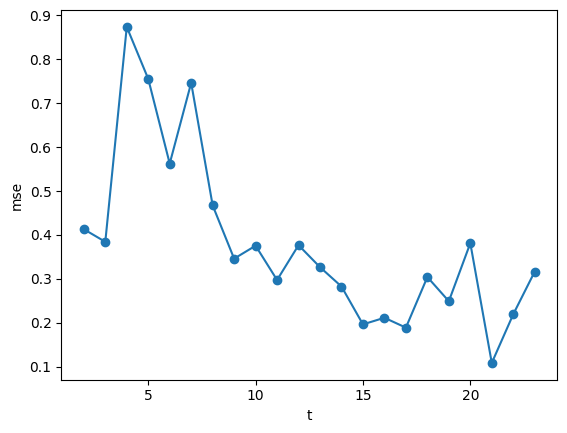

In [12]:
path_csv = r'dataset/t_mse_graf.csv'

rows = []
with open(path_csv) as f:   
    reader = csv.reader(f)
    rows = [row for row in reader]

header = rows.pop(0)

data = np.float_(np.array(rows).T)


fig, ax = plt.subplots()

ax.plot(data[0], data[1], linestyle='solid', marker='o')

ax.set_xlabel(header[0])
ax.set_ylabel(header[1])